In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import phik
from phik.binning import bin_data
import numpy as np
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, OrdinalEncoder, label_binarize, LabelEncoder 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    mean_absolute_error, 
    r2_score,
    auc,
    mean_absolute_percentage_error,
    make_scorer,
    mean_squared_error,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    mean_squared_log_error,
    explained_variance_score,
    median_absolute_error,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
from catboost import CatBoostClassifier, CatBoostRegressor
import optuna
from xgboost import XGBClassifier, XGBRegressor
import mlflow
import joblib

e:\projects\obesity\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv(r"E:\projects\obesity\data\obesity.csv")

data.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,162.0,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,152.0,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,180.0,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,180.0,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,178.0,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


family_history: Страдал ли кто-нибудь из членов семьи избыточным весом?<br>
FAVC: Часто ли вы употребляете высококалорийную пищу?<br>
FCVC: Часто ли вы употребляете овощи в пищу?<br>
NCP: Сколько раз в день вы принимаете основные блюда?<br>
CAEC: Принимаете ли вы какую-либо пищу в перерывах между приемами пищи?<br>
CH2O: Сколько воды вы пьете в день?<br>
SCC: Следите ли вы за количеством потребляемых калорий в день?<br>
FAF: Как часто вы занимаетесь физическими упражнениями?<br>
TUE: Сколько времени вы пользуетесь такими техническими устройствами, как сотовый телефон, видеоигры, телевизор, компьютер и другими?<br>
CALC: Как часто вы употребляете алкоголь?<br>
MTRANS: Каким транспортом вы обычно пользуетесь?<br>

In [3]:
data.isna().sum()

Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

In [4]:
n_uniques = [data[col].nunique() for col in data.columns]
dtypes = data.dtypes

pd.DataFrame({"dtype": dtypes, "n_unique": n_uniques})

,dtype,n_unique
Gender,object,2
Age,float64,1402
Height,float64,1574
Weight,float64,1525
family_history,object,2
FAVC,object,2
FCVC,float64,810
NCP,float64,635
CAEC,object,4
SMOKE,object,2


In [5]:
eda_data = data.copy()

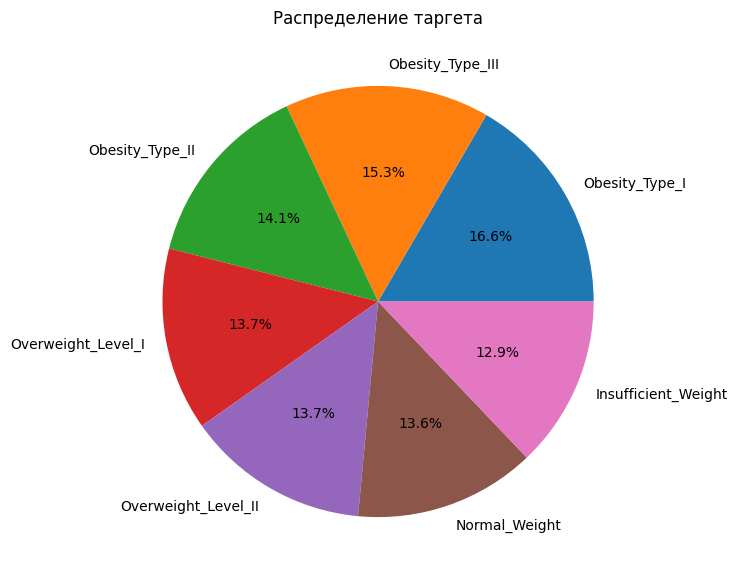

In [6]:
fig, axes = plt.subplots(figsize=(7, 7))
ax = plt.pie(eda_data["Obesity"].value_counts(), labels=eda_data["Obesity"].value_counts().index, autopct="%.1f%%")
plt.title("Распределение таргета")
plt.show()

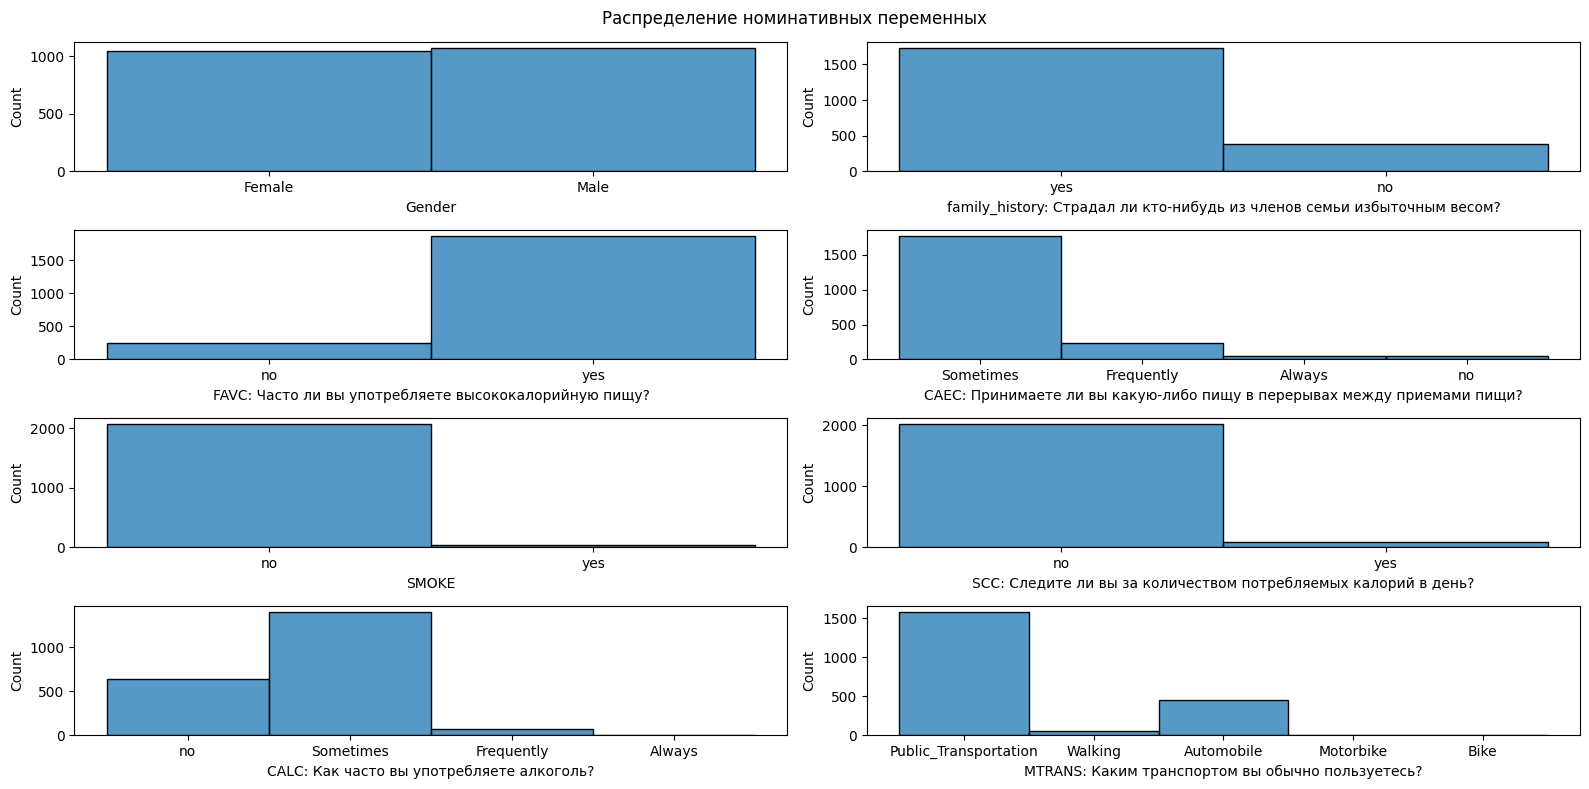

In [7]:
fig, axes = plt.subplots(4, 2, figsize=(16, 8))
plt.suptitle("Распределение номинативных переменных")

ax1 = sns.histplot(data=eda_data, x="Gender", ax=axes[0][0])

ax2 = sns.histplot(data=eda_data, x="family_history", ax=axes[0][1])
ax2.set_xlabel("family_history: Страдал ли кто-нибудь из членов семьи избыточным весом?")

ax3 = sns.histplot(data=eda_data, x="FAVC", ax=axes[1][0])
ax3.set_xlabel("FAVC: Часто ли вы употребляете высококалорийную пищу?")

ax4 = sns.histplot(data=eda_data, x="CAEC", ax=axes[1][1])
ax4.set_xlabel("CAEC: Принимаете ли вы какую-либо пищу в перерывах между приемами пищи?")

ax5 = sns.histplot(data=eda_data, x="SMOKE", ax=axes[2][0])

ax6 = sns.histplot(data=eda_data, x="SCC", ax=axes[2][1])
ax6.set_xlabel("SCC: Следите ли вы за количеством потребляемых калорий в день?")

ax7 = sns.histplot(data=eda_data, x="CALC", ax=axes[3][0])
ax7.set_xlabel("CALC: Как часто вы употребляете алкоголь?")

ax8 = sns.histplot(data=eda_data, x="MTRANS", ax=axes[3][1])
ax8.set_xlabel("MTRANS: Каким транспортом вы обычно пользуетесь?")

plt.tight_layout()
plt.show()

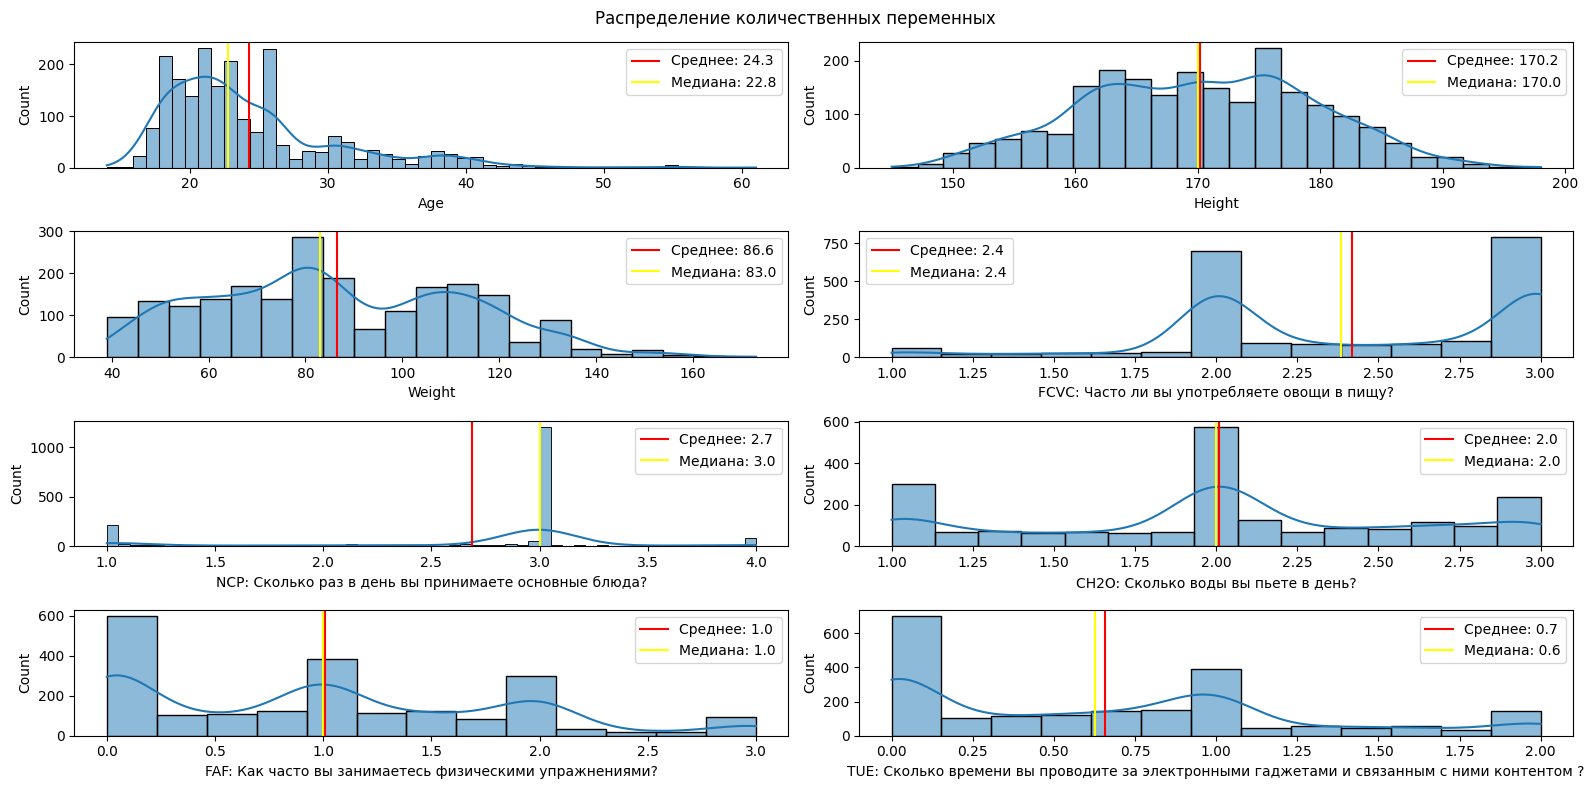

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(16, 8))
plt.suptitle("Распределение количественных переменных")

ax1 = sns.histplot(data=eda_data, x="Age", kde=True, ax=axes[0][0])
ax1.axvline(x=eda_data["Age"].mean(), color="red", label=f"Среднее: {np.round(eda_data["Age"].mean(), 1)}")
ax1.axvline(x=eda_data["Age"].median(), color="yellow", label=f"Медиана: {np.round(eda_data["Age"].median(), 1)}")
ax1.legend()

ax2 = sns.histplot(data=eda_data, x="Height", kde=True, ax=axes[0][1])
ax2.axvline(x=eda_data["Height"].mean(), color="red", label=f"Среднее: {np.round(eda_data["Height"].mean(), 1)}")
ax2.axvline(x=eda_data["Height"].median(), color="yellow", label=f"Медиана: {np.round(eda_data["Height"].median(), 1)}")
ax2.legend()

ax3 = sns.histplot(data=eda_data, x="Weight", kde=True, ax=axes[1][0])
ax3.axvline(x=eda_data["Weight"].mean(), color="red", label=f"Среднее: {np.round(eda_data["Weight"].mean(), 1)}")
ax3.axvline(x=eda_data["Weight"].median(), color="yellow", label=f"Медиана: {np.round(eda_data["Weight"].median(), 1)}")
ax3.legend()

ax4 = sns.histplot(data=eda_data, x="FCVC", kde=True, ax=axes[1][1])
ax4.axvline(x=eda_data["FCVC"].mean(), color="red", label=f"Среднее: {np.round(eda_data["FCVC"].mean(), 1)}")
ax4.axvline(x=eda_data["FCVC"].median(), color="yellow", label=f"Медиана: {np.round(eda_data["FCVC"].median(), 1)}")
ax4.set_xlabel("FCVC: Часто ли вы употребляете овощи в пищу?")
ax4.legend()

ax5 = sns.histplot(data=eda_data, x="NCP", kde=True, ax=axes[2][0])
ax5.axvline(x=eda_data["NCP"].mean(), color="red", label=f"Среднее: {np.round(eda_data["NCP"].mean(), 1)}")
ax5.axvline(x=eda_data["NCP"].median(), color="yellow", label=f"Медиана: {np.round(eda_data["NCP"].median(), 1)}")
ax5.set_xlabel("NCP: Сколько раз в день вы принимаете основные блюда?")
ax5.legend()

ax6 = sns.histplot(data=eda_data, x="CH2O", kde=True, ax=axes[2][1])
ax6.axvline(x=eda_data["CH2O"].mean(), color="red", label=f"Среднее: {np.round(eda_data["CH2O"].mean(), 1)}")
ax6.axvline(x=eda_data["CH2O"].median(), color="yellow", label=f"Медиана: {np.round(eda_data["CH2O"].median(), 1)}")
ax6.set_xlabel("CH2O: Сколько воды вы пьете в день?")
ax6.legend()

ax7 = sns.histplot(data=eda_data, x="FAF", kde=True, ax=axes[3][0])
ax7.axvline(x=eda_data["FAF"].mean(), color="red", label=f"Среднее: {np.round(eda_data["FAF"].mean(), 1)}")
ax7.axvline(x=eda_data["FAF"].median(), color="yellow", label=f"Медиана: {np.round(eda_data["FAF"].median(), 1)}")
ax7.set_xlabel("FAF: Как часто вы занимаетесь физическими упражнениями?")
ax7.legend()

ax8 = sns.histplot(data=eda_data, x="TUE", kde=True, ax=axes[3][1])
ax8.axvline(x=eda_data["TUE"].mean(), color="red", label=f"Среднее: {np.round(eda_data["TUE"].mean(), 1)}")
ax8.axvline(x=eda_data["TUE"].median(), color="yellow", label=f"Медиана: {np.round(eda_data["TUE"].median(), 1)}")
ax8.set_xlabel("TUE: Сколько времени вы проводите за электронными гаджетами и связанным с ними контентом ?")
ax8.legend()

plt.tight_layout()
plt.show()

In [9]:
num_data = eda_data.select_dtypes(exclude="object").copy()

In [10]:
for col in num_data.columns:
    num_data[col] = PowerTransformer(method='yeo-johnson').fit_transform(num_data[[col]])

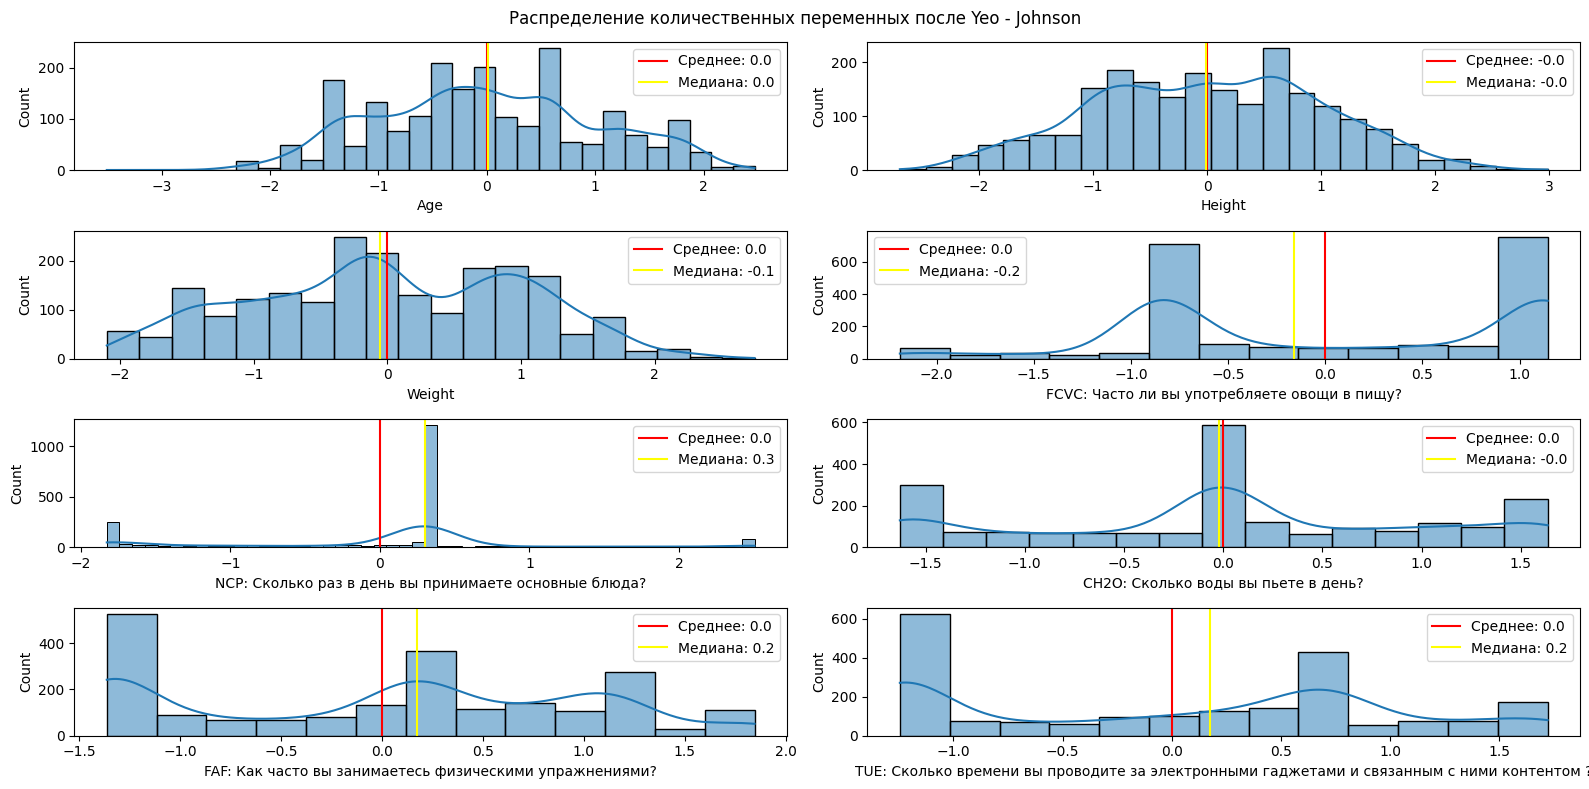

In [11]:
fig, axes = plt.subplots(4, 2, figsize=(16, 8))
plt.suptitle("Распределение количественных переменных после Yeo - Johnson")

ax1 = sns.histplot(data=num_data, x="Age", kde=True, ax=axes[0][0])
ax1.axvline(x=num_data["Age"].mean(), color="red", label=f"Среднее: {np.round(num_data["Age"].mean(), 1)}")
ax1.axvline(x=num_data["Age"].median(), color="yellow", label=f"Медиана: {np.round(num_data["Age"].median(), 1)}")
ax1.legend()

ax2 = sns.histplot(data=num_data, x="Height", kde=True, ax=axes[0][1])
ax2.axvline(x=num_data["Height"].mean(), color="red", label=f"Среднее: {np.round(num_data["Height"].mean(), 1)}")
ax2.axvline(x=num_data["Height"].median(), color="yellow", label=f"Медиана: {np.round(num_data["Height"].median(), 1)}")
ax2.legend()

ax3 = sns.histplot(data=num_data, x="Weight", kde=True, ax=axes[1][0])
ax3.axvline(x=num_data["Weight"].mean(), color="red", label=f"Среднее: {np.round(num_data["Weight"].mean(), 1)}")
ax3.axvline(x=num_data["Weight"].median(), color="yellow", label=f"Медиана: {np.round(num_data["Weight"].median(), 1)}")
ax3.legend()

ax4 = sns.histplot(data=num_data, x="FCVC", kde=True, ax=axes[1][1])
ax4.axvline(x=num_data["FCVC"].mean(), color="red", label=f"Среднее: {np.round(num_data["FCVC"].mean(), 1)}")
ax4.axvline(x=num_data["FCVC"].median(), color="yellow", label=f"Медиана: {np.round(num_data["FCVC"].median(), 1)}")
ax4.set_xlabel("FCVC: Часто ли вы употребляете овощи в пищу?")
ax4.legend()

ax5 = sns.histplot(data=num_data, x="NCP", kde=True, ax=axes[2][0])
ax5.axvline(x=num_data["NCP"].mean(), color="red", label=f"Среднее: {np.round(num_data["NCP"].mean(), 1)}")
ax5.axvline(x=num_data["NCP"].median(), color="yellow", label=f"Медиана: {np.round(num_data["NCP"].median(), 1)}")
ax5.set_xlabel("NCP: Сколько раз в день вы принимаете основные блюда?")
ax5.legend()

ax6 = sns.histplot(data=num_data, x="CH2O", kde=True, ax=axes[2][1])
ax6.axvline(x=num_data["CH2O"].mean(), color="red", label=f"Среднее: {np.round(num_data["CH2O"].mean(), 1)}")
ax6.axvline(x=num_data["CH2O"].median(), color="yellow", label=f"Медиана: {np.round(num_data["CH2O"].median(), 1)}")
ax6.set_xlabel("CH2O: Сколько воды вы пьете в день?")
ax6.legend()

ax7 = sns.histplot(data=num_data, x="FAF", kde=True, ax=axes[3][0])
ax7.axvline(x=num_data["FAF"].mean(), color="red", label=f"Среднее: {np.round(num_data["FAF"].mean(), 1)}")
ax7.axvline(x=num_data["FAF"].median(), color="yellow", label=f"Медиана: {np.round(num_data["FAF"].median(), 1)}")
ax7.set_xlabel("FAF: Как часто вы занимаетесь физическими упражнениями?")
ax7.legend()

ax8 = sns.histplot(data=num_data, x="TUE", kde=True, ax=axes[3][1])
ax8.axvline(x=num_data["TUE"].mean(), color="red", label=f"Среднее: {np.round(num_data["TUE"].mean(), 1)}")
ax8.axvline(x=num_data["TUE"].median(), color="yellow", label=f"Медиана: {np.round(num_data["TUE"].median(), 1)}")
ax8.set_xlabel("TUE: Сколько времени вы проводите за электронными гаджетами и связанным с ними контентом ?")
ax8.legend()

plt.tight_layout()
plt.show()

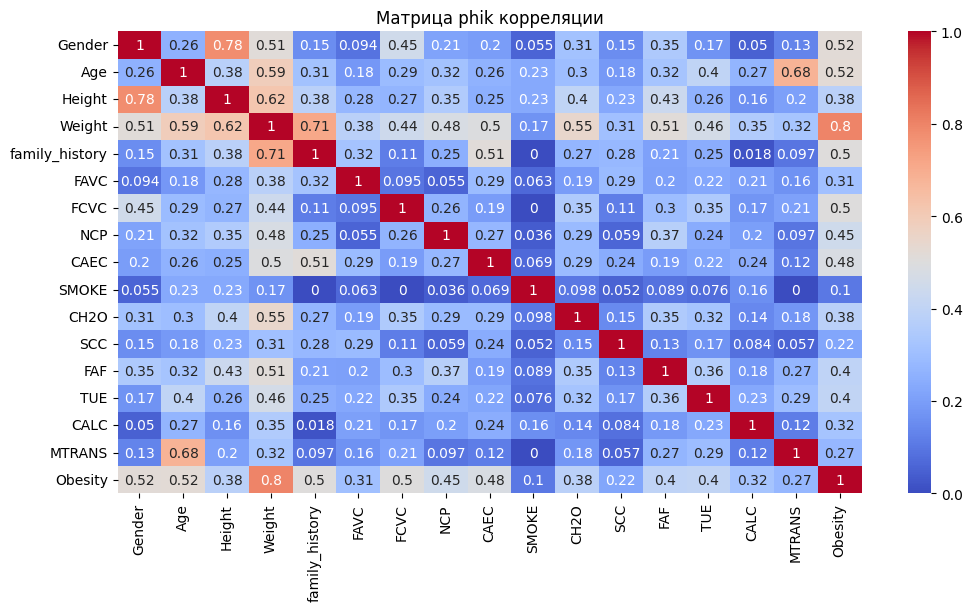

In [12]:
fig, axes = plt.subplots(figsize=(12, 6))
ax = sns.heatmap(eda_data.phik_matrix(interval_cols=eda_data.select_dtypes(exclude="object").columns), cmap="coolwarm", annot=True)
ax.set_title("Матрица phik корреляции")
plt.show()

In [13]:
corr_data = eda_data[["Age", "Height", "Weight", "MTRANS", "FAF", "Obesity"]].copy()

In [14]:
data_binned, binning_dict = bin_data(corr_data, cols=["Age", "Height", "Weight", "FAF"], retbins=True)

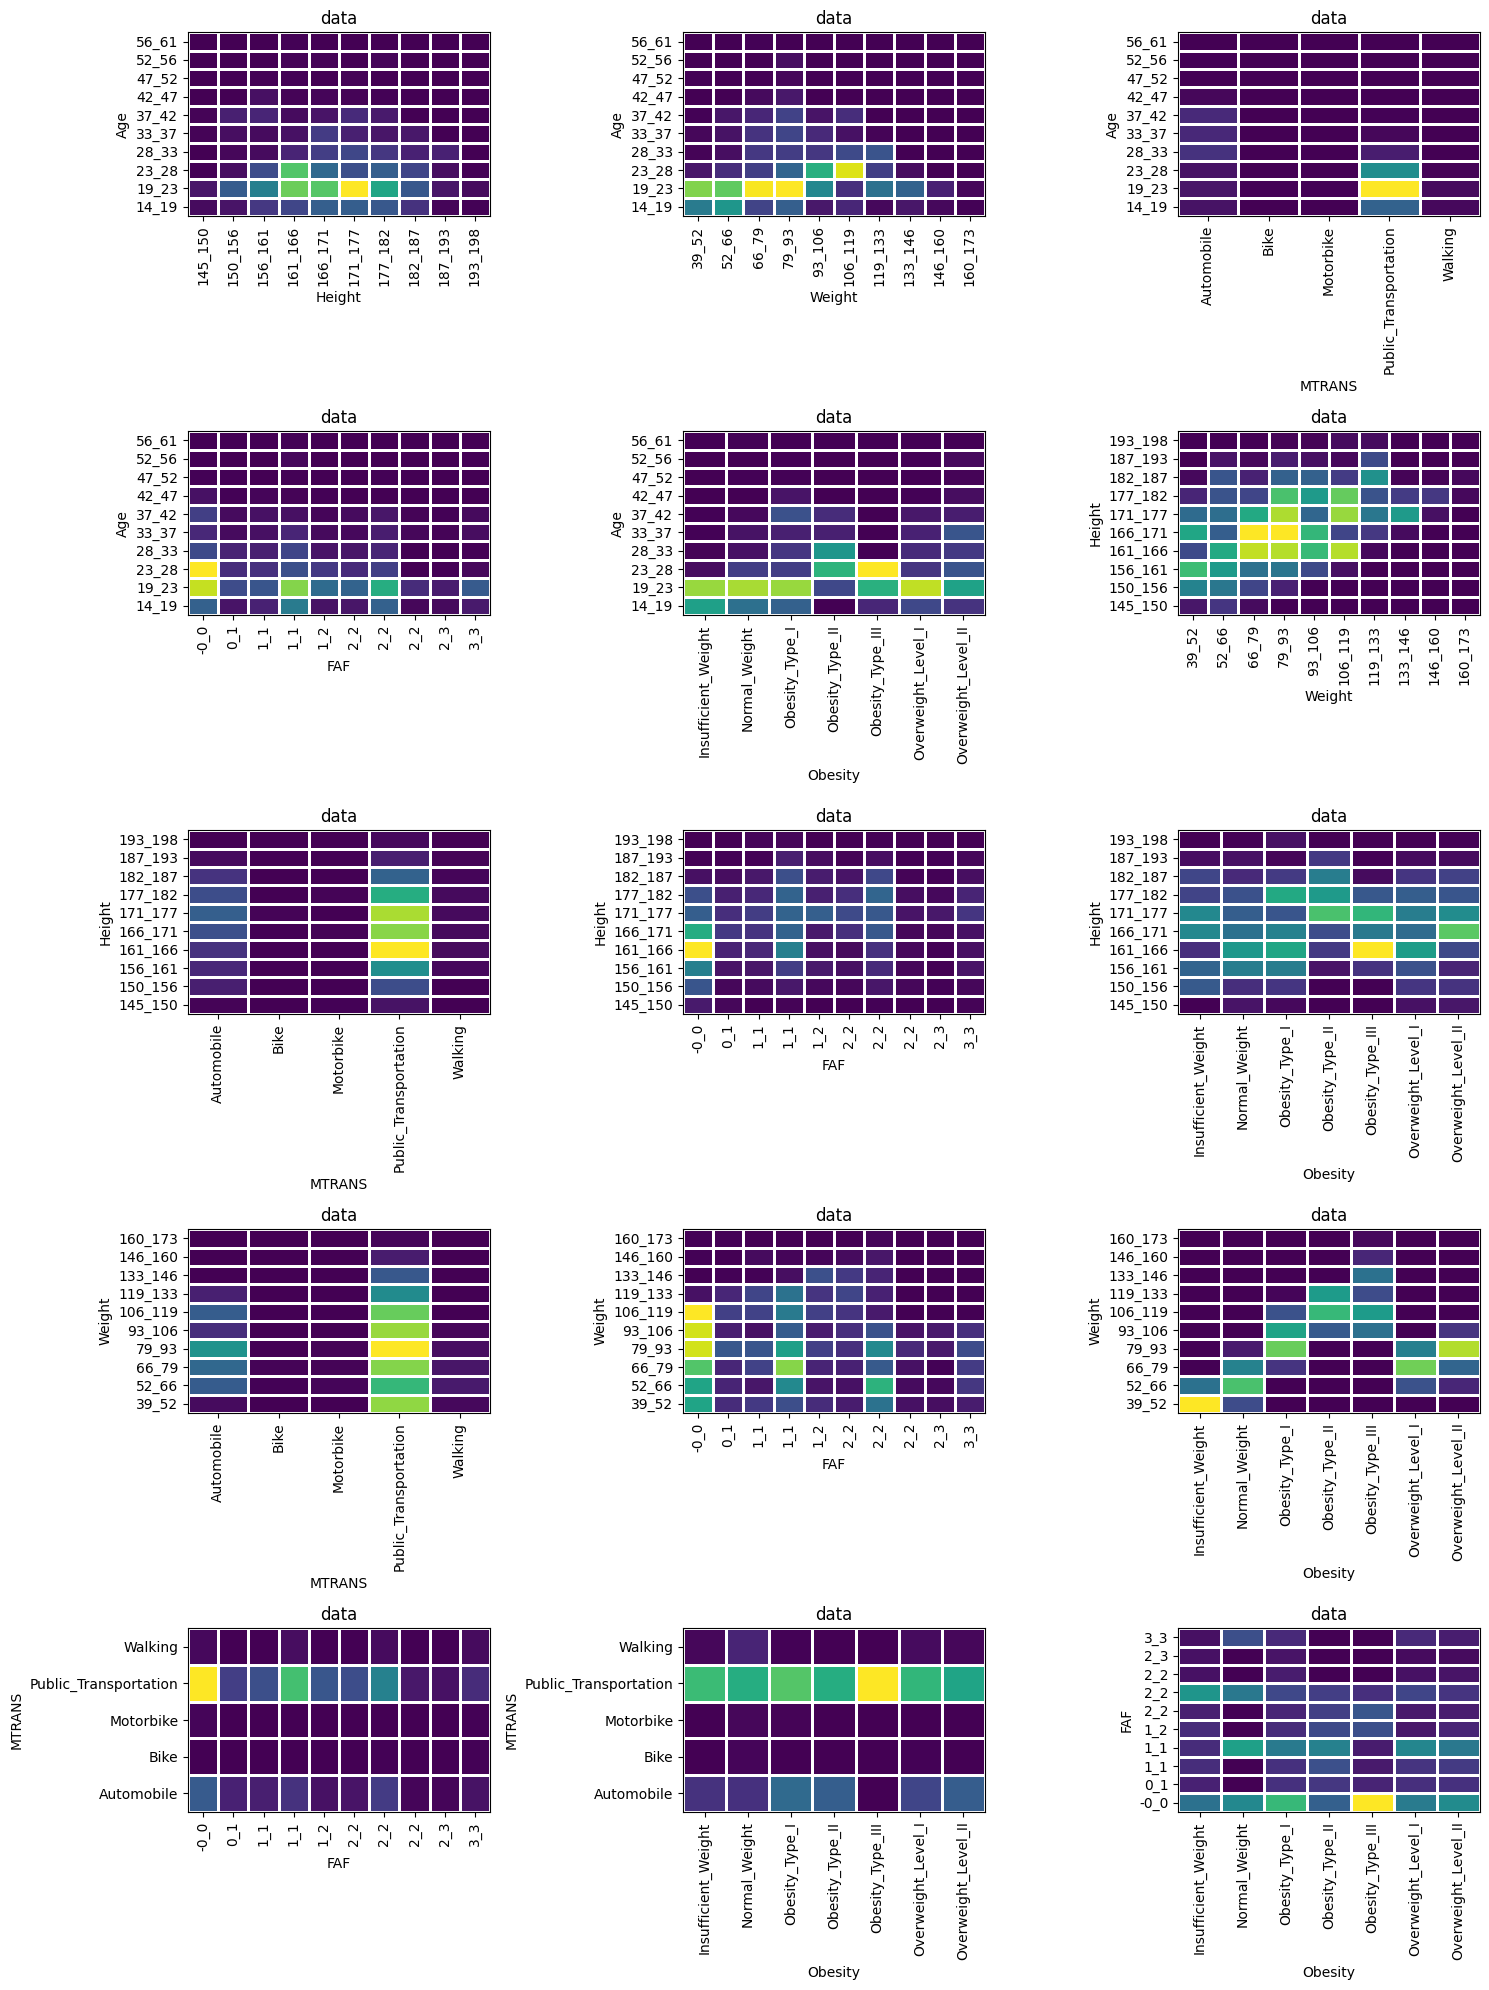

In [15]:
plt.rc('text', usetex=False)

n=0
for i in range(corr_data.shape[1]):
    n=n+i
    
ncols=3
nrows=int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15,4*nrows))
ndecimals = 0

for i, comb in enumerate(itertools.combinations(data_binned.columns.values, 2)):
    
    c = int(i%ncols)
    r = int((i-c)/ncols )

    # get data
    c0, c1 = comb
    datahist = data_binned.groupby([c0,c1], observed=False)[c0].count().to_frame().unstack().fillna(0)
    datahist.columns = datahist.columns.droplevel()
    
    # plot data
    img = axes[r][c].pcolormesh(datahist.values, edgecolor='w', linewidth=1)
    
    # axis ticks and tick labels
    if c0 in binning_dict.keys():
        ylabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c0][i][0], binning_dict[c0][i][1])
                   for i in range(len(binning_dict[c0]))]
    else:
        ylabels = datahist.index

    if c1 in binning_dict.keys():        
        xlabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c1][i][0], binning_dict[c1][i][1])
                    for i in range(len(binning_dict[c1]))]
    else:
        xlabels = datahist.columns
    
    # axis labels
    axes[r][c].set_yticks(np.arange(len(ylabels)) + 0.5)
    axes[r][c].set_xticks(np.arange(len(xlabels)) + 0.5)
    axes[r][c].set_xticklabels(xlabels, rotation='vertical')
    axes[r][c].set_yticklabels(ylabels, rotation='horizontal')    
    axes[r][c].set_xlabel(datahist.columns.name)
    axes[r][c].set_ylabel(datahist.index.name)    
    axes[r][c].set_title('data')
    
plt.tight_layout()

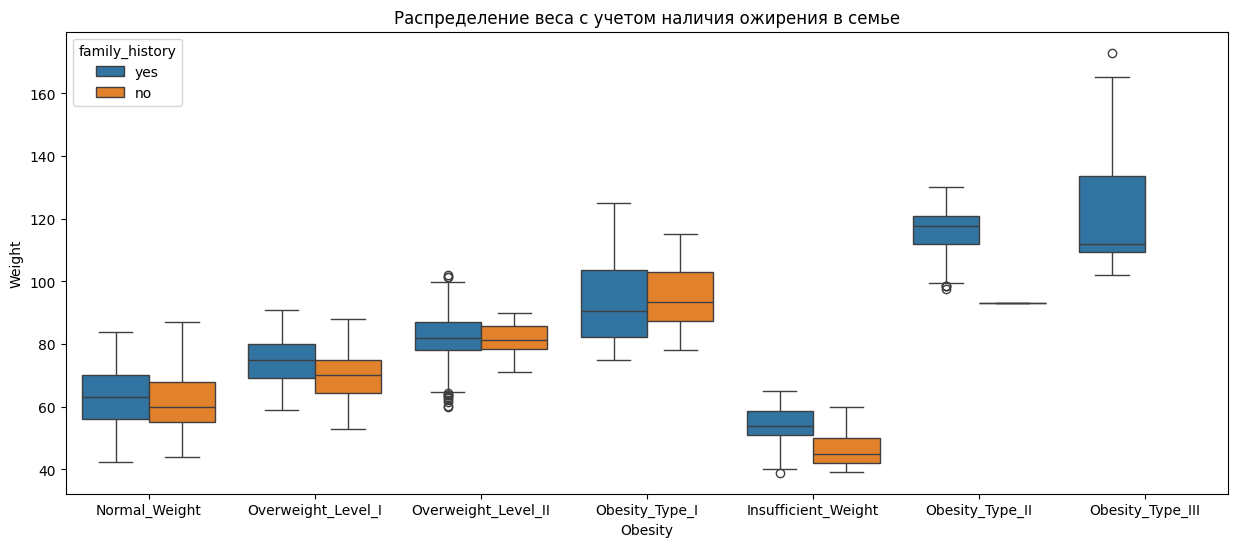

In [16]:
fig, axes = plt.subplots(figsize=(15, 6))
ax = sns.boxplot(data=eda_data, x="Obesity", y="Weight", hue="family_history")
ax.set_title("Распределение веса с учетом наличия ожирения в семье")
plt.show()

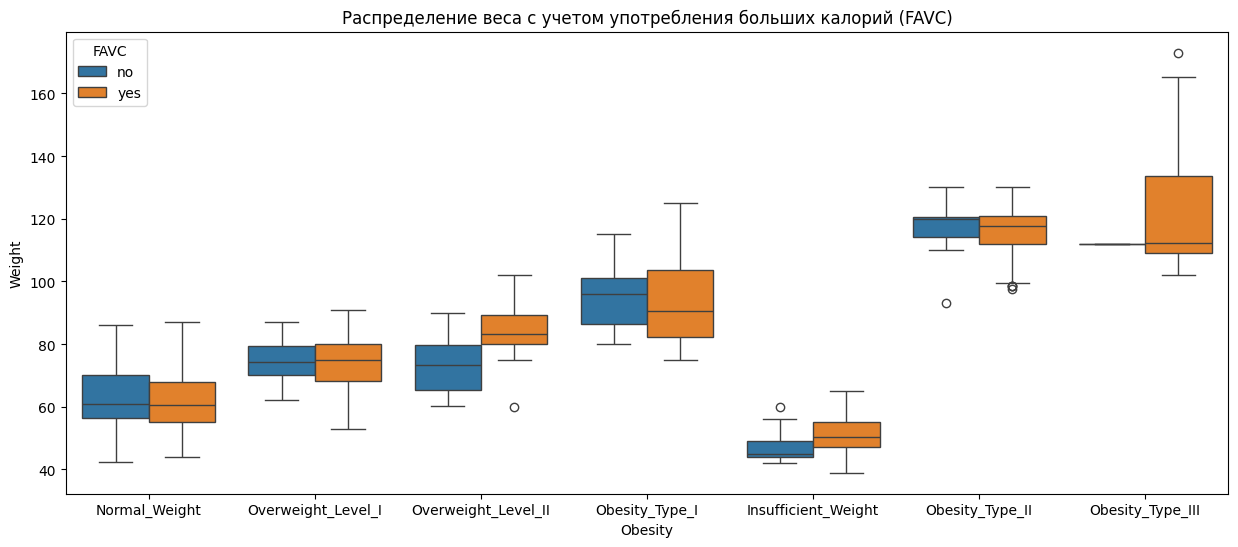

In [17]:
fig, axes = plt.subplots(figsize=(15, 6))
ax = sns.boxplot(data=eda_data, x="Obesity", y="Weight", hue="FAVC")
ax.set_title("Распределение веса с учетом употребления больших калорий (FAVC)")
plt.show()

In [18]:
eda_data["FAF_binned"] = pd.cut(
    eda_data["FAF"], bins=np.arange(0, 4, 1, dtype=float), labels=["Маленький уровень активности", "Средний уровень активности", "Высокий уровень активности"], include_lowest=True
    )

In [19]:
fafo = eda_data.groupby(["FAF_binned", "Obesity"], observed=False).agg(count=("FAF_binned", "count")).reset_index()

fafo["total"] = fafo.groupby("FAF_binned", observed=False)["count"].transform("sum")
fafo["precentage"] = np.round(fafo["count"] / fafo["total"] * 100, 1)

fafo

,FAF_binned,Obesity,count,total,precentage
0,Маленький уровень активности,Insufficient_Weight,115,1245,9.2
1,Маленький уровень активности,Normal_Weight,177,1245,14.2
2,Маленький уровень активности,Obesity_Type_I,215,1245,17.3
3,Маленький уровень активности,Obesity_Type_II,151,1245,12.1
4,Маленький уровень активности,Obesity_Type_III,207,1245,16.6
5,Маленький уровень активности,Overweight_Level_I,185,1245,14.9
6,Маленький уровень активности,Overweight_Level_II,195,1245,15.7
7,Средний уровень активности,Insufficient_Weight,122,673,18.1
8,Средний уровень активности,Normal_Weight,69,673,10.3
9,Средний уровень активности,Obesity_Type_I,87,673,12.9


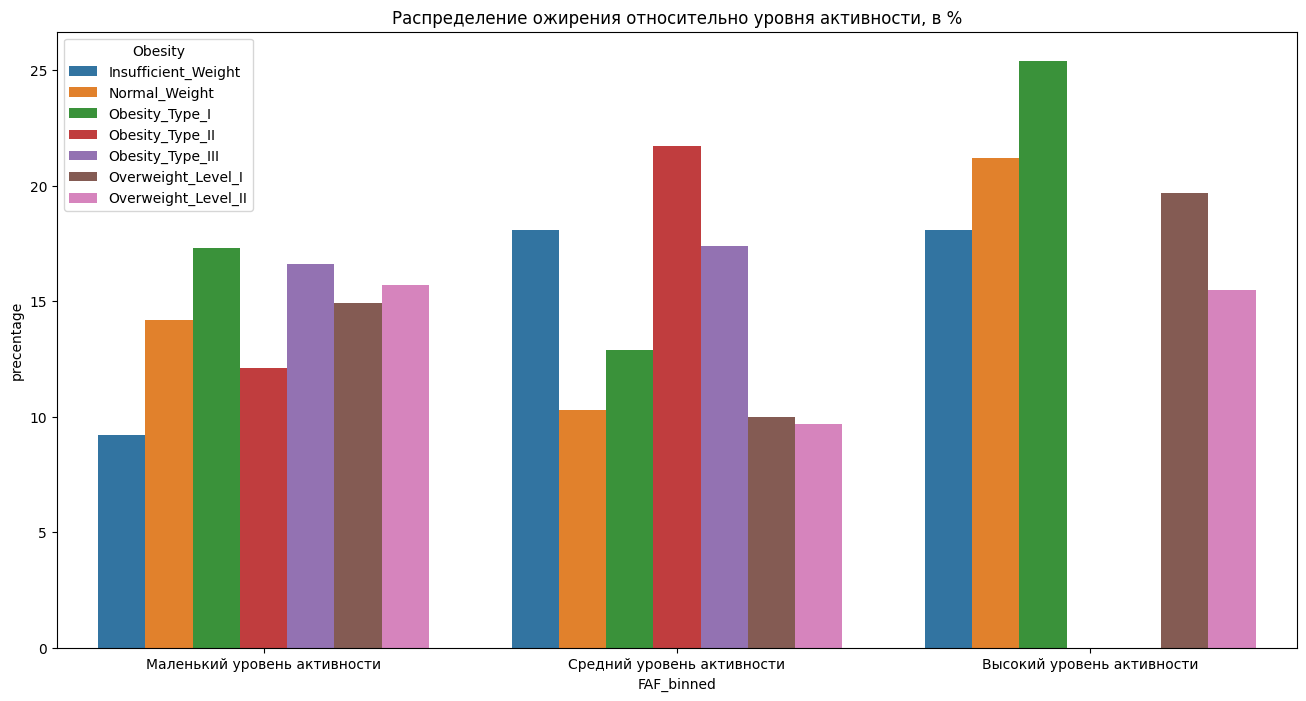

In [20]:
fig, axes = plt.subplots(figsize=(16, 8))
ax = sns.barplot(x=fafo.FAF_binned, y=fafo.precentage, hue=fafo.Obesity)
ax.set_title('Распределение ожирения относительно уровня активности, в %')
plt.show()

In [21]:
eda_data["FCVC_binned"] = pd.cut(eda_data["FCVC"], bins=np.arange(0, 4, 1, dtype=float), labels=["Малое кол-во овощей", "Среднее кол-во овощей", "Большое кол-во овощей"])
eda_data["NCP_binned"] = pd.cut(eda_data["NCP"], bins=[0, 3, 4], labels=["До трех основных блюд", "Больше трех основных блюд"])

In [22]:
foodo = eda_data.groupby(["FCVC_binned", "NCP_binned", "Obesity"], observed=False).agg(count=("Obesity", "count")).reset_index()

foodo["total"] = foodo.groupby(["FCVC_binned"], observed=False)["count"].transform("sum")
foodo["precentage"] = np.round(foodo["count"] / foodo["total"] * 100, 1)

foodo

,FCVC_binned,NCP_binned,Obesity,count,total,precentage
0,Малое кол-во овощей,До трех основных блюд,Insufficient_Weight,2,33,6.1
1,Малое кол-во овощей,До трех основных блюд,Normal_Weight,17,33,51.5
2,Малое кол-во овощей,До трех основных блюд,Obesity_Type_I,3,33,9.1
3,Малое кол-во овощей,До трех основных блюд,Obesity_Type_II,1,33,3.0
4,Малое кол-во овощей,До трех основных блюд,Obesity_Type_III,0,33,0.0
5,Малое кол-во овощей,До трех основных блюд,Overweight_Level_I,3,33,9.1
6,Малое кол-во овощей,До трех основных блюд,Overweight_Level_II,3,33,9.1
7,Малое кол-во овощей,Больше трех основных блюд,Insufficient_Weight,2,33,6.1
8,Малое кол-во овощей,Больше трех основных блюд,Normal_Weight,1,33,3.0
9,Малое кол-во овощей,Больше трех основных блюд,Obesity_Type_I,0,33,0.0


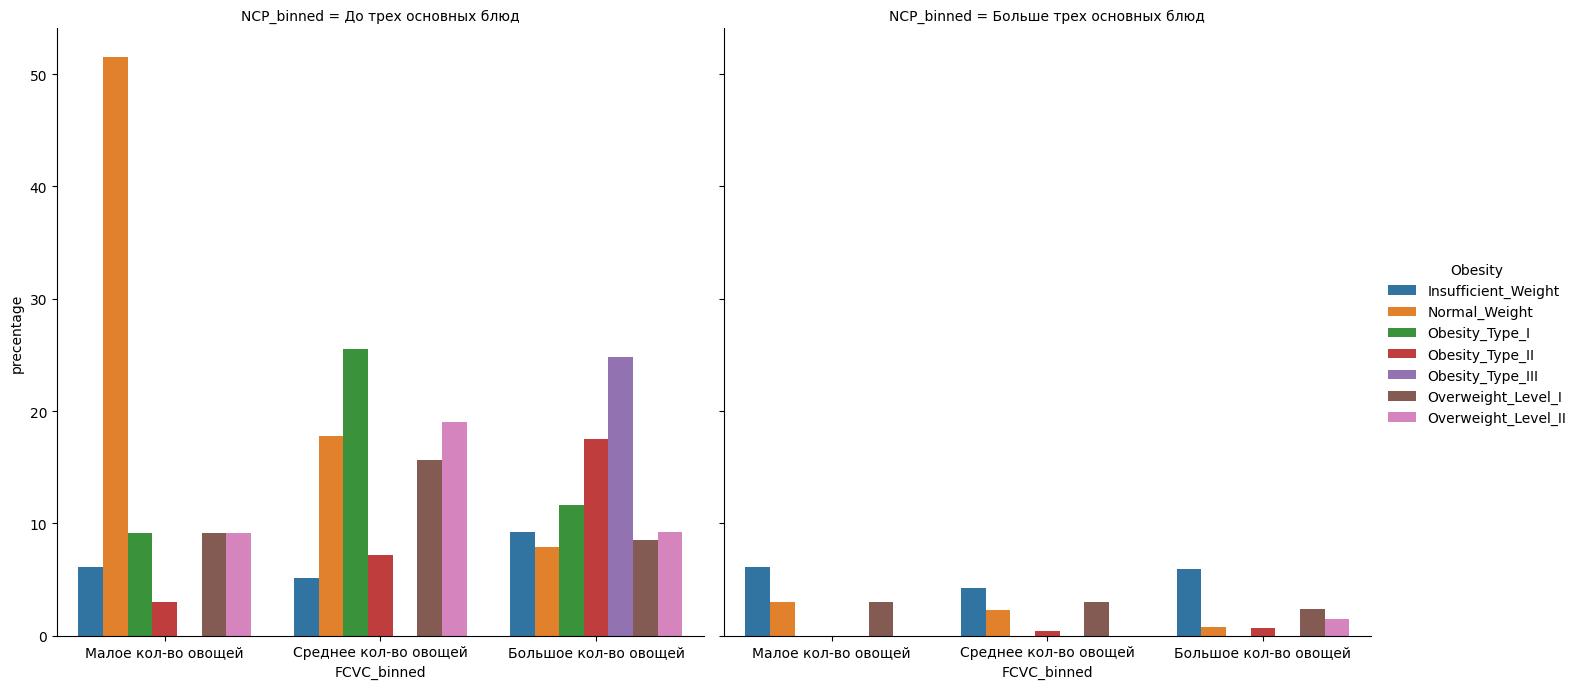

In [23]:
sns.catplot(x=foodo.FCVC_binned, y=foodo.precentage, hue=foodo.Obesity, col=foodo.NCP_binned, kind="bar", height=7)
plt.show()

In [24]:
data["Obesity"] = data["Obesity"].map({
    "Insufficient_Weight": 0,
    "Normal_Weight": 1,
    "Overweight_Level_I": 2,
    "Overweight_Level_II": 3,
    "Obesity_Type_I": 4,
    "Obesity_Type_II": 5,
    "Obesity_Type_III": 6
})

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("Obesity", axis=1), data["Obesity"], stratify=data["Obesity"], test_size=0.2, random_state=42)

In [26]:
num_cols = X_train.select_dtypes(exclude="object").columns.to_list()
binary_cat = [col for col in X_train.select_dtypes(include="object") if X_train[col].nunique() == 2]
cat_cols = X_train.select_dtypes(include="object").columns.difference(binary_cat).to_list()

In [27]:
cat_ord = Pipeline([
    ("ord", OrdinalEncoder())
])

In [28]:
cat_ohe = Pipeline([
    ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

In [29]:
num_pipe = Pipeline([
    ("pt", PowerTransformer(method="yeo-johnson"))
])

In [30]:
transformer = ColumnTransformer([
    ("cat_pipe_ord", cat_ord, binary_cat),
    ("cat_pipe", cat_ohe, cat_cols),
    ("num_pipe", num_pipe, num_cols)
])

In [31]:
xgb_ovr_clf = Pipeline([
    ("transformer", transformer),
    ("model", OneVsRestClassifier(XGBClassifier(random_state=42)))
])

In [32]:
def objective_xgb_ovr_clf(trial):
    params = {
        "model__estimator__eta": trial.suggest_float("model__estimator__eta", 0, 1),
        "model__estimator__n_estimators": trial.suggest_categorical("model__estimator__n_estimators", [1000]),
        "model__estimator__max_depth": trial.suggest_int("model__estimator__max_depth", 6, 100),
        "model__estimator__gamma": trial.suggest_float("model__estimator__gamma", 0, 1),
        "model__estimator__lambda": trial.suggest_float("model__estimator__lambda", 0, 5),
        "model__estimator__alpha": trial.suggest_float("model__estimator__alpha", 0, 10),
        "model__estimator__min_child_weight": trial.suggest_float("model__estimator__min_child_weight", 0, 10)
    }

    xgb_ovr_clf.set_params(**params)
    score = make_scorer(f1_score, average="weighted")

    return cross_val_score(xgb_ovr_clf, X_train, y_train, cv=5, scoring=score).mean()

In [33]:
study_xgb_ovr_clf = optuna.create_study(direction='maximize')

[I 2025-05-01 00:50:29,500] A new study created in memory with name: no-name-69a3bb1b-86c1-4ab5-a421-5ae9d95c8aab


In [34]:
study_xgb_ovr_clf.optimize(objective_xgb_ovr_clf, n_trials=100)

[I 2025-05-01 00:50:37,819] Trial 0 finished with value: 0.9145151034864295 and parameters: {'model__estimator__eta': 0.8550110531499029, 'model__estimator__n_estimators': 1000, 'model__estimator__max_depth': 23, 'model__estimator__gamma': 0.5845347681573816, 'model__estimator__lambda': 3.571656914810404, 'model__estimator__alpha': 5.679558909109156, 'model__estimator__min_child_weight': 3.5964909737942294}. Best is trial 0 with value: 0.9145151034864295.
[I 2025-05-01 00:50:49,219] Trial 1 finished with value: 0.9216009159368417 and parameters: {'model__estimator__eta': 0.5017379595919342, 'model__estimator__n_estimators': 1000, 'model__estimator__max_depth': 47, 'model__estimator__gamma': 0.575233225780539, 'model__estimator__lambda': 0.5675800963220767, 'model__estimator__alpha': 3.72668079269618, 'model__estimator__min_child_weight': 7.813386052959148}. Best is trial 1 with value: 0.9216009159368417.
[I 2025-05-01 00:50:57,311] Trial 2 finished with value: 0.8929453763629802 and pa

In [35]:
xgb_ovr_clf = xgb_ovr_clf.set_params(**study_xgb_ovr_clf.best_params)

xgb_ovr_clf.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat_pipe_ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Gender', 'family_history',
                                                   'FAVC', 'SMOKE', 'SCC']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CAEC', 'CALC', 'MTRANS']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('pt',
                                                                   PowerTransformer())])...
                                                             feature_weights=None,
                                                             gamma=0.056382095202161184,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             lambda=4.036711877108179,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=43,
                                                             max_leaves=None,
                                                             min_child_weight=0.6069599565586321,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None, ...)))])

In [36]:
xgb_clf = Pipeline([
    ("transformer", transformer),
    ("model", XGBClassifier(random_state=42))
])

In [37]:
def objective_xgb_clf(trial):
    params = {
        "model__objective": trial.suggest_categorical("model__objective", ["multi:softprob"]),
        "model__eta": trial.suggest_float("model__eta", 0, 1),
        "model__n_estimators": trial.suggest_categorical("model__n_estimators", [1000]),
        "model__max_depth": trial.suggest_int("model__max_depth", 6, 100),
        "model__gamma": trial.suggest_float("model__gamma", 0, 1),
        "model__lambda": trial.suggest_float("model__lambda", 0, 5),
        "model__alpha": trial.suggest_float("model__alpha", 0, 10),
        "model__min_child_weight": trial.suggest_float("model__min_child_weight", 0, 10)
    }

    xgb_clf.set_params(**params)
    score = make_scorer(f1_score, average="weighted")

    return cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring=score).mean()

In [38]:
study_xgb_clf = optuna.create_study(direction='maximize')

[I 2025-05-01 01:04:42,992] A new study created in memory with name: no-name-a833b113-ff56-494e-a0bf-7911b43e71a7


In [39]:
study_xgb_clf.optimize(objective_xgb_clf, n_trials=100)

[I 2025-05-01 01:04:49,511] Trial 0 finished with value: 0.9417827919133022 and parameters: {'model__objective': 'multi:softprob', 'model__eta': 0.9426632262390846, 'model__n_estimators': 1000, 'model__max_depth': 55, 'model__gamma': 0.8056482388341553, 'model__lambda': 0.2515490088569916, 'model__alpha': 0.5241934071527232, 'model__min_child_weight': 6.172689990706179}. Best is trial 0 with value: 0.9417827919133022.
[I 2025-05-01 01:04:55,956] Trial 1 finished with value: 0.9262147437393076 and parameters: {'model__objective': 'multi:softprob', 'model__eta': 0.8339274583234019, 'model__n_estimators': 1000, 'model__max_depth': 48, 'model__gamma': 0.3031719326394202, 'model__lambda': 1.833249543731088, 'model__alpha': 3.1139173874983506, 'model__min_child_weight': 4.0864684592798}. Best is trial 0 with value: 0.9417827919133022.
[I 2025-05-01 01:05:02,401] Trial 2 finished with value: 0.9406134952738153 and parameters: {'model__objective': 'multi:softprob', 'model__eta': 0.994051846646

In [40]:
xgb_clf = xgb_clf.set_params(**study_xgb_clf.best_params)

xgb_clf.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat_pipe_ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Gender', 'family_history',
                                                   'FAVC', 'SMOKE', 'SCC']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CAEC', 'CALC', 'MTRANS']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('pt',
                                                                   PowerTransformer())])...
                               feature_weights=None, gamma=0.08152902323161104,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               lambda=4.8525072242160014, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=71, max_leaves=None,
                               min_child_weight=5.4209152773127895, missing=nan,
                               monotone_constraints=None, multi_strategy=None, ...))])

In [41]:
catboost_ovr_clf = OneVsRestClassifier(
    CatBoostClassifier(cat_features=cat_cols + binary_cat, random_state=42)
)

In [42]:
catboost_ovr_clf.fit(X_train, y_train)

Learning rate set to 0.012883
0:	learn: 0.6640783	total: 198ms	remaining: 3m 17s
1:	learn: 0.6373270	total: 217ms	remaining: 1m 48s
2:	learn: 0.6117114	total: 236ms	remaining: 1m 18s
3:	learn: 0.5881895	total: 258ms	remaining: 1m 4s
4:	learn: 0.5629642	total: 279ms	remaining: 55.5s
5:	learn: 0.5404547	total: 298ms	remaining: 49.4s
6:	learn: 0.5153449	total: 318ms	remaining: 45.1s
7:	learn: 0.4944845	total: 338ms	remaining: 41.9s
8:	learn: 0.4699213	total: 358ms	remaining: 39.5s
9:	learn: 0.4565211	total: 376ms	remaining: 37.2s
10:	learn: 0.4353202	total: 395ms	remaining: 35.5s
11:	learn: 0.4213068	total: 415ms	remaining: 34.1s
12:	learn: 0.4041892	total: 435ms	remaining: 33.1s
13:	learn: 0.3870846	total: 455ms	remaining: 32s
14:	learn: 0.3711994	total: 474ms	remaining: 31.1s
15:	learn: 0.3559082	total: 494ms	remaining: 30.4s
16:	learn: 0.3416909	total: 514ms	remaining: 29.7s
17:	learn: 0.3301535	total: 540ms	remaining: 29.5s
18:	learn: 0.3163263	total: 560ms	remaining: 28.9s
19:	learn:

OneVsRestClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x000001DAA99C6B10>)

In [43]:
catboost_clf = CatBoostClassifier(cat_features=cat_cols+binary_cat, random_state=42)

In [44]:
catboost_clf.fit(X_train, y_train)

Learning rate set to 0.081268
0:	learn: 1.7442391	total: 42.6ms	remaining: 42.6s
1:	learn: 1.5971731	total: 76.8ms	remaining: 38.3s
2:	learn: 1.4944481	total: 109ms	remaining: 36.3s
3:	learn: 1.3940988	total: 143ms	remaining: 35.5s
4:	learn: 1.3059759	total: 178ms	remaining: 35.4s
5:	learn: 1.2275994	total: 212ms	remaining: 35.1s
6:	learn: 1.1712302	total: 246ms	remaining: 34.9s
7:	learn: 1.1070773	total: 279ms	remaining: 34.6s
8:	learn: 1.0567062	total: 313ms	remaining: 34.5s
9:	learn: 1.0092863	total: 349ms	remaining: 34.5s
10:	learn: 0.9693146	total: 381ms	remaining: 34.3s
11:	learn: 0.9341423	total: 414ms	remaining: 34.1s
12:	learn: 0.8954582	total: 449ms	remaining: 34.1s
13:	learn: 0.8624498	total: 483ms	remaining: 34s
14:	learn: 0.8329986	total: 528ms	remaining: 34.7s
15:	learn: 0.7979781	total: 563ms	remaining: 34.6s
16:	learn: 0.7742720	total: 597ms	remaining: 34.5s
17:	learn: 0.7471294	total: 632ms	remaining: 34.5s
18:	learn: 0.7252164	total: 667ms	remaining: 34.4s
19:	learn: 

In [45]:
xgb_reg = Pipeline([
    ("transformer", transformer),
    ("model", XGBRegressor(random_state=42))
])

In [46]:
def objective_xgb_reg(trial):
    params = {
        "model__objective": trial.suggest_categorical("model__objective", ["reg:squarederror"]),
        "model__eta": trial.suggest_float("model__eta", 0, 1),
        "model__n_estimators": trial.suggest_categorical("model__n_estimators", [1000]),
        "model__max_depth": trial.suggest_int("model__max_depth", 6, 100),
        "model__gamma": trial.suggest_float("model__gamma", 0, 1),
        "model__lambda": trial.suggest_float("model__lambda", 0, 5),
        "model__alpha": trial.suggest_float("model__alpha", 0, 10),
        "model__min_child_weight": trial.suggest_float("model__min_child_weight", 0, 10)
    }

    xgb_reg.set_params(**params)
    score = make_scorer(mean_squared_error)

    return cross_val_score(xgb_reg, X_train, y_train, cv=5, scoring=score).mean()

In [47]:
study_xgb_reg = optuna.create_study(direction='minimize')

[I 2025-05-01 01:21:08,642] A new study created in memory with name: no-name-36982519-6214-4a6c-a212-9cd9fa8bdeec


In [48]:
study_xgb_reg.optimize(objective_xgb_reg, n_trials=100)

[I 2025-05-01 01:21:09,742] Trial 0 finished with value: 0.11637410521507263 and parameters: {'model__objective': 'reg:squarederror', 'model__eta': 0.888612484097599, 'model__n_estimators': 1000, 'model__max_depth': 93, 'model__gamma': 0.7061920923455727, 'model__lambda': 4.132151102672831, 'model__alpha': 6.2262831060523744, 'model__min_child_weight': 1.4453992567730156}. Best is trial 0 with value: 0.11637410521507263.
[I 2025-05-01 01:21:10,884] Trial 1 finished with value: 0.04787534885108471 and parameters: {'model__objective': 'reg:squarederror', 'model__eta': 0.1408733992782497, 'model__n_estimators': 1000, 'model__max_depth': 7, 'model__gamma': 0.7223184638246873, 'model__lambda': 0.34020175348900283, 'model__alpha': 0.36389966515528394, 'model__min_child_weight': 5.874447654634002}. Best is trial 1 with value: 0.04787534885108471.
[I 2025-05-01 01:21:11,864] Trial 2 finished with value: 0.12687723338603973 and parameters: {'model__objective': 'reg:squarederror', 'model__eta': 

In [49]:
xgb_reg = xgb_reg.set_params(**study_xgb_reg.best_params)

xgb_reg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat_pipe_ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Gender', 'family_history',
                                                   'FAVC', 'SMOKE', 'SCC']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CAEC', 'CALC', 'MTRANS']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('pt',
                                                                   PowerTransformer())])...
                              feature_weights=None,
                              gamma=0.00031725805979678813, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              lambda=1.7862493787055493, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=48, max_leaves=None,
                              min_child_weight=8.195028303941152, missing=nan,
                              monotone_constraints=None, multi_strategy=None, ...))])

In [50]:
catboost_reg = CatBoostRegressor(cat_features=cat_cols+binary_cat, random_state=42)

In [51]:
catboost_reg.fit(X_train, y_train)

Learning rate set to 0.044474
0:	learn: 1.9112502	total: 15ms	remaining: 15s
1:	learn: 1.8391357	total: 31.1ms	remaining: 15.5s
2:	learn: 1.7744974	total: 46.4ms	remaining: 15.4s
3:	learn: 1.7096889	total: 64.7ms	remaining: 16.1s
4:	learn: 1.6433787	total: 82.4ms	remaining: 16.4s
5:	learn: 1.5819352	total: 100ms	remaining: 16.6s
6:	learn: 1.5211669	total: 118ms	remaining: 16.7s
7:	learn: 1.4662341	total: 135ms	remaining: 16.7s
8:	learn: 1.4146771	total: 153ms	remaining: 16.8s
9:	learn: 1.3652717	total: 171ms	remaining: 17s
10:	learn: 1.3169617	total: 183ms	remaining: 16.5s
11:	learn: 1.2730928	total: 202ms	remaining: 16.6s
12:	learn: 1.2265400	total: 220ms	remaining: 16.7s
13:	learn: 1.1861059	total: 238ms	remaining: 16.7s
14:	learn: 1.1448880	total: 256ms	remaining: 16.8s
15:	learn: 1.1036914	total: 274ms	remaining: 16.9s
16:	learn: 1.0680250	total: 293ms	remaining: 16.9s
17:	learn: 1.0345074	total: 310ms	remaining: 16.9s
18:	learn: 0.9979690	total: 327ms	remaining: 16.9s
19:	learn: 0

In [52]:
def report_metrics(mlflow, y_test, y_pred, y_proba, sufix):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average='weighted',)
    cm = confusion_matrix(y_test, y_pred) 
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy_{sufix}: {accuracy}")
    print(f"Precision_{sufix}: {precision}")
    print(f"Recall_{sufix}: {recall}")
    print(f"F1 Score_{sufix}: {f1}")
    print(f"Balanced Accuracy_{sufix}: {balanced_accuracy}")
    print(f"Confusion Matrix_{sufix}:\n", cm)

    mlflow.log_metric(f"accuracy_{sufix}", accuracy)
    mlflow.log_metric(f"precision_{sufix}", precision)
    mlflow.log_metric(f"recall_{sufix}", recall)
    mlflow.log_metric(f"f1_score_{sufix}", f1)
    mlflow.log_metric(f"balanced_accuracy_{sufix}", balanced_accuracy)
    mlflow.log_text(f"Confusion Matrix:\n{cm}", f"confusion_matrix_{sufix}.txt")

    y_bin = label_binarize(y_test, classes=range(len(y_test)))
    fpr, tpr = {}, {}

    plt.figure(figsize=(8, 6))
    for i in range(len(np.unique(y_test))):
        fpr[i], tpr[i], _ = roc_curve(y_bin[i], y_proba[:, i])
        roc_auc = roc_auc_score(y_bin[i], y_proba[:, i])
        plt.plot(fpr[i], tpr[i], label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    mlflow.log_figure(plt.gcf(), f"roc_curves_{sufix}.png")
    plt.close()

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test.nunique())]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(y_test.nunique()):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= y_test.nunique()
    macro_auc = auc(all_fpr, mean_tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(all_fpr, mean_tpr, color='b', label=f'Macro - average ROC (AUC = {macro_auc:.2f})', lw=2)
    plt.plot([0, 1], [0, 1], '--', lw=2)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro - averaged ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    mlflow.log_figure(plt.gcf(), f"macro-roc_curve_{sufix}.png")
    plt.close()


In [ ]:
def mlflow_run(best_pipeline, best_params, X_test, y_test, ovr=False):
    mlflow.log_params(best_params)

    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)

    report_metrics(mlflow, y_test, y_pred, y_proba, 'ml')

    mlflow.sklearn.log_model(best_pipeline, "model_pipeline")

    if ovr:
        try:
            importances = []

            for i in range(y_test.nunique()):
                importances.append(best_pipeline.estimators_[i].feature_importances_)
            
            importances = pd.DataFrame(columns=X_train.columns.to_list(), data=importances).mean().values
            feature_names = X_train.columns.to_list()

        except:
            importances = []

            for i in range(y_test.nunique()):
                importances.append(best_pipeline.named_steps["model"].estimators_[i].feature_importances_)

            importances = pd.DataFrame(columns=best_pipeline.named_steps["transformer"].get_feature_names_out(), data=importances).mean().values
            feature_names = best_pipeline.named_steps["transformer"].get_feature_names_out()
    else:
        try:
            importances = best_pipeline.feature_importances_
            feature_names = X_test.columns.to_list()
        except:
            importances = best_pipeline.named_steps['model'].feature_importances_
            feature_names = best_pipeline.named_steps['transformer'].get_feature_names_out()

    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    feat_imp_df = feat_imp_df[feat_imp_df['importance'] > 0].head(40)
    total_importance = feat_imp_df['importance'].sum()
    feat_imp_df['importance_fraction'] = feat_imp_df['importance'] / total_importance
    
    fig, ax = plt.subplots(figsize=(25, 25))
    bars = ax.barh(feat_imp_df['feature'], feat_imp_df['importance_fraction'], color='skyblue')
    ax.invert_yaxis()
    
    ax.set_title("Feature Importances from XGBoost")
    ax.set_xlabel("Importance (%)")
    ax.set_ylabel("Features")
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    
    for bar in bars:
        width = bar.get_width()
        label_text = f"{width:.1%}"
        ax.text(
            width + 0.01,
            bar.get_y() + bar.get_height() / 2,
            label_text,
            va='center'
        )
    
    mlflow.log_figure(plt.gcf(), "feature_importances.png")

    feat_imp_df.to_csv("feature_importances.csv", index=False)
    mlflow.log_artifact("feature_importances.csv")
    
    plt.close()

    print("\nRun finished. All results have been logged to MLflow.")

In [54]:
mlflow.set_experiment("Obesity")

<Experiment: artifact_location='file:///e:/projects/obesity/mlruns/943000151270760839', creation_time=1745761615916, experiment_id='943000151270760839', last_update_time=1745761615916, lifecycle_stage='active', name='Obesity', tags={}>

In [55]:
name = "xgb_ovr_clf"

with mlflow.start_run(run_name=f"{name}_experiment"):
    mlflow_run(xgb_ovr_clf, {}, X_test, y_test, True)

Accuracy_ml: 0.9479905437352246
Precision_ml: 0.949436560928476
Recall_ml: 0.9479905437352246
F1 Score_ml: 0.9479625057448738
Balanced Accuracy_ml: 0.9461171559693727
Confusion Matrix_ml:
 [[51  3  0  0  0  0  0]
 [ 1 56  1  0  0  0  0]
 [ 0  5 50  3  0  0  0]
 [ 0  0  2 53  3  0  0]
 [ 0  0  0  1 69  0  0]
 [ 0  0  0  0  2 58  0]
 [ 0  0  0  0  0  1 64]]


2025/05/01 01:24:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run finished. All results have been logged to MLflow.


In [56]:
name = "xgb_clf"

with mlflow.start_run(run_name=f"{name}_experiment"):
    mlflow_run(xgb_clf, {}, X_test, y_test)

Accuracy_ml: 0.9432624113475178
Precision_ml: 0.9465597581568816
Recall_ml: 0.9432624113475178
F1 Score_ml: 0.9433349501646957
Balanced Accuracy_ml: 0.941008599136678
Confusion Matrix_ml:
 [[50  4  0  0  0  0  0]
 [ 1 57  0  0  0  0  0]
 [ 0  6 49  3  0  0  0]
 [ 0  1  2 52  3  0  0]
 [ 0  0  0  1 69  0  0]
 [ 0  0  0  0  2 58  0]
 [ 0  0  0  0  0  1 64]]


2025/05/01 01:24:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run finished. All results have been logged to MLflow.


In [57]:
name = "catboost_ovr_clf"

with mlflow.start_run(run_name=f"{name}_experiment"):
    mlflow_run(catboost_ovr_clf, {}, X_test, y_test, True)

Accuracy_ml: 0.9550827423167849
Precision_ml: 0.9562465959969667
Recall_ml: 0.9550827423167849
F1 Score_ml: 0.9550596648870611
Balanced Accuracy_ml: 0.9530840806702876
Confusion Matrix_ml:
 [[51  3  0  0  0  0  0]
 [ 0 56  2  0  0  0  0]
 [ 0  5 50  3  0  0  0]
 [ 0  0  2 55  1  0  0]
 [ 0  0  0  0 70  0  0]
 [ 0  0  0  0  1 58  1]
 [ 0  0  0  0  0  1 64]]


2025/05/01 01:24:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run finished. All results have been logged to MLflow.


In [58]:
name = "catboost_clf"

with mlflow.start_run(run_name=f"{name}_experiment"):
    mlflow_run(catboost_clf, {}, X_test, y_test)

Accuracy_ml: 0.9456264775413712
Precision_ml: 0.9480808667861907
Recall_ml: 0.9456264775413712
F1 Score_ml: 0.9460343670887267
Balanced Accuracy_ml: 0.9432318639215191
Confusion Matrix_ml:
 [[51  3  0  0  0  0  0]
 [ 1 54  3  0  0  0  0]
 [ 0  8 50  0  0  0  0]
 [ 0  0  3 53  2  0  0]
 [ 0  0  0  0 70  0  0]
 [ 0  0  0  0  1 58  1]
 [ 0  0  0  0  0  1 64]]


2025/05/01 01:24:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run finished. All results have been logged to MLflow.


In [59]:
def report_metrics2(mlflow, y_test, y_pred, sufix):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * ((y_test.shape[0] - 1) / (y_test.shape[0] - 16 - 1))
    msle = mean_squared_log_error(y_test, y_pred)
    medAE = median_absolute_error(y_test, y_pred)
    exp_var = explained_variance_score(y_test, y_pred)

    print(f"MAE {sufix}: {mae}")
    print(f"MSE {sufix}: {mse}")
    print(f"RMSE {sufix}: {rmse}")
    print(f"MAPE {sufix}: {mape}")
    print(f"R^2 {sufix}: {r2}")
    print(f"Adj. R^2 {sufix}: {adj_r2}")
    print(f"MSLE {sufix}: {msle}")
    print(f"medAE {sufix}: {medAE}")
    print(f"Explained Var. {sufix}: {exp_var}")

    mlflow.log_metric(f"MAE {sufix}", mae)
    mlflow.log_metric(f"MSE {sufix}", mse)
    mlflow.log_metric(f"RMSE {sufix}", rmse)
    mlflow.log_metric(f"MAPE {sufix}", mape)
    mlflow.log_metric(f"R2 {sufix}", r2)
    mlflow.log_metric(f"Adj. R2 {sufix}", adj_r2)
    mlflow.log_metric(f"MSLE {sufix}", msle)
    mlflow.log_metric(f"medAE {sufix}", medAE)
    mlflow.log_metric(f"Exp. Var. {sufix}", exp_var)


In [60]:
def mlflow_run2(best_pipeline, best_params, X_test, y_test):
    mlflow.log_params(best_params)

    y_pred = best_pipeline.predict(X_test)

    report_metrics2(mlflow, y_test, y_pred, "ml")

    mlflow.sklearn.log_model(best_pipeline, "model_pipeline")

    try:
        importances = best_pipeline.feature_importances_
        feature_names = X_test.columns.to_list()
    except:
        importances = best_pipeline.named_steps["model"].feature_importances_
        feature_names = best_pipeline.named_steps["transformer"].get_feature_names_out()
    
    feat_imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    feat_imp_df = feat_imp_df[feat_imp_df["importance"] > 0].head(40)
    total_importance = feat_imp_df["importance"].sum()
    feat_imp_df["importance_fraction"] = feat_imp_df["importance"] / total_importance

    fig, ax = plt.subplots(figsize=(25, 25))
    bars = ax.barh(feat_imp_df["feature"], feat_imp_df["importance_fraction"], color="skyblue")
    ax.invert_yaxis()

    ax.set_title("Feature importances from model")
    ax.set_xlabel("Importance (%)")
    ax.set_ylabel("Features")
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

    for bar in bars:
        width = bar.get_width()
        label_text = f"{width:.1%}"

        ax.text(
            width + 0.01,
            bar.get_y() + bar.get_height() / 2,
            label_text,
            va='center'
        )
    
    mlflow.log_figure(plt.gcf(), "feature_importances.png")

    feat_imp_df.to_csv("feature_importances.csv", index=False)
    mlflow.log_artifact("feature_importances.csv")
    
    plt.close()

    print("\nRun finished. All results have been logged to MLflow.")


In [61]:
name = "xgb_reg"

with mlflow.start_run(run_name=f"{name}_experiment"):
    mlflow_run2(xgb_reg, {}, X_test, y_test)

MAE ml: 0.08856742084026337
MSE ml: 0.04169686138629913
RMSE ml: 0.2041980934933016
MAPE ml: 4495234406809600.0
R^2 ml: 0.9894087910652161
Adj. R^2 ml: 0.9889914035209881
MSLE ml: 0.005472107324749231
medAE ml: 0.024727344512939453
Explained Var. ml: 0.9894302522419676


2025/05/01 01:24:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run finished. All results have been logged to MLflow.


In [62]:
name = "catboost_reg"

with mlflow.start_run(run_name=f"{name}_experiment"):
    mlflow_run2(catboost_reg, {}, X_test, y_test)

MAE ml: 0.12165138322260152
MSE ml: 0.03609408610870441
RMSE ml: 0.18998443649074104
MAPE ml: 6327908790768880.0
R^2 ml: 0.9908319344757984
Adj. R^2 ml: 0.990470631400953
MSLE ml: 0.006575401104032698
medAE ml: 0.07242174873198515
Explained Var. ml: 0.9908663974706527


2025/05/01 01:24:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run finished. All results have been logged to MLflow.


In [63]:
pd.set_option('display.max_rows', None)  
all_preds = pd.DataFrame({"xgb preds":np.round(xgb_reg.predict(X_test)).clip(0, 6).astype('int')})
all_preds["cat_preds"] = np.round(catboost_reg.predict(X_test)).clip(0, 6).astype("int")
all_preds["real_preds"] = y_test.values
all_preds['xgb_raw_preds'] = xgb_reg.predict(X_test)
all_preds["raw_cat_preds"] = catboost_reg.predict(X_test)

all_preds

,xgb preds,cat_preds,real_preds,xgb_raw_preds,raw_cat_preds
0,0,0,0,-0.080045,-0.076287
1,1,1,1,0.625390,0.519107
2,6,6,6,5.999164,5.989834
3,4,4,4,4.047180,4.122673
4,3,3,3,2.944993,2.980378
5,2,2,2,2.005203,2.020302
6,3,3,3,2.981274,3.076183
7,1,1,1,1.109589,0.975161
8,3,3,3,2.938982,2.957757
9,5,5,5,5.006957,5.018943


In [64]:
def predicted_preds(best_model):
    df = []
    max_len = len(np.unique(y_test))
    preds = best_model.predict(X_test)
    for pred in preds:
        row = {}
        for i in range(max_len):
            if i == 0:
                res = min(max(1 - pred, 0), 1)
            elif i == max_len - 1:
                res = min(max(pred - (i - 1), 0), 1)
            else:
                if pred < i:
                    res = max(1 - i + pred, 0)
                else:
                    res = max(1 + i - pred, 0)

            row[i] = round(res)

        df.append(row)

    print(pd.DataFrame(df))

In [65]:
predicted_preds(xgb_reg)

     0  1  2  3  4  5  6
0    1  0  0  0  0  0  0
1    0  1  0  0  0  0  0
2    0  0  0  0  0  0  1
3    0  0  0  0  1  0  0
4    0  0  0  1  0  0  0
5    0  0  1  0  0  0  0
6    0  0  0  1  0  0  0
7    0  1  0  0  0  0  0
8    0  0  0  1  0  0  0
9    0  0  0  0  0  1  0
10   1  0  0  0  0  0  0
11   0  1  0  0  0  0  0
12   0  0  0  0  1  0  0
13   0  0  0  0  0  1  0
14   0  1  0  0  0  0  0
15   0  0  0  0  0  1  0
16   0  0  1  0  0  0  0
17   0  0  1  0  0  0  0
18   0  0  0  0  0  0  1
19   0  1  0  0  0  0  0
20   0  1  0  0  0  0  0
21   0  0  0  1  0  0  0
22   0  0  0  1  0  0  0
23   0  0  0  0  0  1  0
24   0  0  0  0  0  0  1
25   0  0  0  0  0  1  0
26   0  0  1  0  0  0  0
27   0  0  0  0  1  0  0
28   0  0  0  0  0  0  1
29   0  0  1  0  0  0  0
30   0  0  0  1  0  0  0
31   0  0  1  0  0  0  0
32   0  0  0  0  0  1  0
33   0  0  0  0  0  1  0
34   0  0  0  0  1  0  0
35   0  1  0  0  0  0  0
36   0  0  0  0  1  0  0
37   1  0  0  0  0  0  0
38   0  0  0  0  0  1  0


In [66]:
predicted_preds(catboost_reg)

     0  1  2  3  4  5  6
0    1  0  0  0  0  0  0
1    0  1  0  0  0  0  0
2    0  0  0  0  0  0  1
3    0  0  0  0  1  0  0
4    0  0  0  1  0  0  0
5    0  0  1  0  0  0  0
6    0  0  0  1  0  0  0
7    0  1  0  0  0  0  0
8    0  0  0  1  0  0  0
9    0  0  0  0  0  1  0
10   1  0  0  0  0  0  0
11   0  1  0  0  0  0  0
12   0  0  0  0  1  0  0
13   0  0  0  0  0  1  0
14   0  1  0  0  0  0  0
15   0  0  0  0  0  1  0
16   0  0  1  0  0  0  0
17   0  0  1  0  0  0  0
18   0  0  0  0  0  0  1
19   0  1  0  0  0  0  0
20   0  1  0  0  0  0  0
21   0  0  0  1  0  0  0
22   0  0  0  1  0  0  0
23   0  0  0  0  0  1  0
24   0  0  0  0  0  0  1
25   0  0  0  0  0  1  0
26   0  0  1  0  0  0  0
27   0  0  0  0  1  0  0
28   0  0  0  0  0  0  1
29   0  0  1  0  0  0  0
30   0  0  0  1  0  0  0
31   0  0  1  0  0  0  0
32   0  0  0  0  0  1  0
33   0  0  0  0  0  1  0
34   0  0  0  0  1  0  0
35   0  1  0  0  0  0  0
36   0  0  0  0  1  0  0
37   1  0  0  0  0  0  0
38   0  0  0  0  0  1  0


In [2]:
logged_model = 'runs:/9bd21252a9874bbcb82ef6d9693e0a77/model_pipeline'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [12]:
joblib.dump(loaded_model._model_impl, "model.pkl")

['model.pkl']